In [1]:
from acoustic_analyser import frame
import numpy as np

test_frame = frame.from_file(
    member_file="test_member.json", constraint_file="test_constraint.csv", debug=False
)

free_end = test_frame.fixed_end(member_id=0)
free_end = test_frame.free_end(member_id=3)

In [2]:
test_frame.get_determinant(w=2 * np.pi * 13.74)

(-4.985620703437661e-06-1.0202193438770063e-05j)

In [3]:
test_frame.get_natural_frequency_newton(initial_guess=13)

Determinant: (-1.9789594506374817e-05-5.702386671261734e-05j)
Determinant: (-1.9774789839807467e-05-5.693871170213575e-05j)
Determinant: (2.3873507886657814e-06+4.4684536347078085e-06j)
Determinant: (-1.2676177184674352e-07-2.4401193059983066e-07j)
Determinant: (-3.499592272890332e-10-6.726747993528352e-10j)
Determinant: (5.366142656525862e-14+1.0496862082812047e-13j)
Determinant: (-6.387457942448606e-16+5.259426836504137e-16j)


13.897070478349427

In [ ]:
# _ = test_frame.get_frequency_graph(lower_limit=4, upper_limit=7, step_size=0.1)
# # test_frame.get_natural_frequency_newton(initial_guess=10)
# test_frame.get_natural_frequency_bisect(lower_limit=5, upper_limit=5.5)

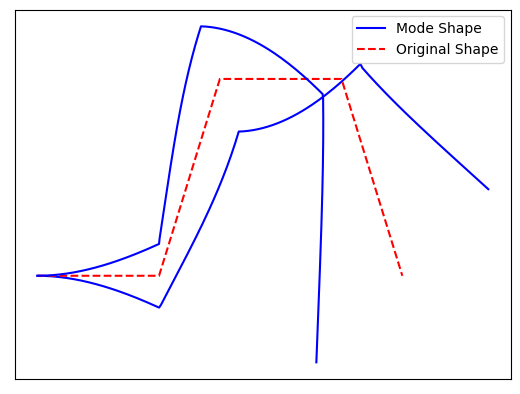

In [5]:
_ = test_frame.get_mode_shape(natural_freq=13.897)